# 3 - Telco Customer Churn: Modelling Data
## Predictive Model Exploration
### Alden Chico

---

## Premise

Now that we prepared the Telco service dataset, it's time to find a good model to predict whether or not a user will churn. We'll follow a disciplined approach in modeling by starting with the simplest binary classification model - logistic regression. After we gather baseline F1 and accuracy metrics using logistic regression, we'll explore binary tree classification and random forest classification. By the end of this process, we should have a good idea on how classic machine learning models perform on the Telco datasets before fitting our data onto deep learning based models.

---

## Importing Telco Churn Datasets

Before we can begin modeling our data, let's start by importing the datasets we created on the all features and selected feature Telco data.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import the Telco churn dataset with all OHE features from CSV file
data_all = pd.read_csv('output/2-EDA/all_features_telco.csv', index_col='customerID')
data_all = data_all.drop('Unnamed: 0', axis=1)
data_all.head()

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_0,SeniorCitizen_1,tenure,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,0,0,1,1,0,1,0,0,1,...,0,0,1,0,1,0,1,29.85,29.85,0
5575-GNVDE,0,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,0,34,56.95,1889.50,0
3668-QPYBK,0,1,1,0,1,0,0,1,1,0,...,0,0,0,1,1,0,2,53.85,108.15,1
7795-CFOCW,0,1,1,0,1,0,1,0,0,1,...,1,0,0,0,1,0,45,42.30,1840.75,0
9237-HQITU,1,0,1,0,1,0,0,1,1,0,...,0,0,1,0,1,0,2,70.70,151.65,1


In [3]:
# Import the Telco churn dataset with selected OHE features from CSV file
data_clean = pd.read_csv('output/2-EDA/clean_telco.csv', index_col='customerID')
data_clean = data_clean.drop('Unnamed: 0', axis=1)
data_clean.head()

,gender_Female,gender_Male,OnlineSecurity_No,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,TechSupport_No,StreamingMovies_No,Contract_Month-to-month,PaymentMethod_Electronic check,tenure,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,,,,,,,
7590-VHVEG,1,0,1,0,1,1,1,1,1,1,1,29.85,29.85,0
5575-GNVDE,0,1,0,1,0,0,1,1,0,0,34,56.95,1889.50,0
3668-QPYBK,0,1,0,0,1,1,1,1,1,0,2,53.85,108.15,1
7795-CFOCW,0,1,0,1,0,0,0,1,0,0,45,42.30,1840.75,0
9237-HQITU,1,0,1,1,0,1,1,1,1,1,2,70.70,151.65,1


---

## Preparing the Results Function

In order to evaluate model performance, ```sklearn``` offers the ```classification_report``` and ```confusion_matrix``` functions that compares the model's predicted labels against their expected labels. The classification report yields a useful metric called the F1-score that we'll use to evaluate model performance along with accuracy. Since the data in the Telco dataset is around 70% users that didn't churn and 30% users that did, there's a class imbalance that has to be taken into consideration when evaluating model performance. F1-score combines precision (the model's ability to make a correct guess) and recall (the model's ability to correctly guess a label with respect to all the observations with that given label) to score the model between zero (being the worst) and one (being the best). The following function takes in the expected and predicted results from a model and returns complete evaluation metrics for the given model.

In [4]:
# Function that plots confusion matrix / classification report after making predictions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_results(y_test, y_pred, output_dict=False):
    cr = classification_report(y_test, y_pred, output_dict=output_dict)
    # Display results if plot_results doesn't want to return classification report
    if output_dict == False:
        conf_mat = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(conf_mat, index = ['Did Not Churn', 'Churn'],
                          columns = ['Did Not Churn', 'Churn'])
        _ = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
        _ = plt.title('Churn Confusion Matrix', fontsize=20)
        _ = plt.ylabel('True', fontsize=14)
        _ = plt.xlabel('Predicted', fontsize=14)
        _ = plt.show()
        print(cr)
    # Only return classification report if desire dictionary results
    return cr

---

## Preparing Data for Modelling

As with all model evaluation, it's best to train-test split the entire dataset so we can evaluate how the model will perform on unseen data. 3-Fold cross-validation will be performed exclusively on training data and labels to find the best-fit model. We will use the test split to evaluate the model's final performance metrics since the model has not been exposed on this set of data in training.

In [5]:
# Train-Test split the two datasets
from sklearn.model_selection import train_test_split

y_all = data_all['churn']
X_all = data_all.drop('churn', axis=1)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all,
                                                                    test_size=0.2,
                                                                    random_state=42)

y_clean = data_clean['churn']
X_clean = data_clean.drop('churn', axis=1)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, 
                                                                            y_clean,
                                                                            test_size=0.2,
                                                                            random_state=42)

---

## Best Classifier Function

```sklearn``` offers a useful function called ```GridSearchCV``` that automatically runs cross-validation on all combinations of a model and its specified parameters. Using the ```best_clf``` function, we'll run GridSearchCV on a model and return the model with best-fit given the provided parameters.

In [6]:
# Function to find best classifier using GridSearchCV
from sklearn.model_selection import GridSearchCV
# Ignore sklearn FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def best_clf(clf, params, X_train, y_train, cv=3):
    best_clf = GridSearchCV(clf, params, cv=cv)
    _ = best_clf.fit(X_train, y_train)
    return best_clf

---

## Create and Plot Accuracy and F1-Scores to Evaluate Model

The following ```plot_f1_acc``` function plots the F1-Score and accuracy for each model separated by the dataset. Since there are two evaluation metrics and two datasets we'll be modeling on, ```plot_f1_acc``` creates four separate plots.

In [7]:
f1_dict_all = {}
acc_dict_all = {}

f1_dict_clean = {}
acc_dict_clean = {}

In [8]:
# Plot the change in F1-scores over the different NN models
def plot_f1_acc(f1_dict, acc_dict, f1_dict_clean, acc_dict_clean):
    
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    
    # Gather f1_dict values and keys from all dataset
    list_val = list(f1_dict.values())
    list_keys = list(f1_dict.keys())
    avg_f1_score = np.mean(list_val)
    
    # Gather acc_dict values and keys from all dataset
    list_acc = list(acc_dict.values())
    list_acc_keys = list(acc_dict.keys())
    avg_acc_score = np.mean(list_acc)
    
    # Gather f1_dict values and keys from all dataset
    list_val_clean = list(f1_dict_clean.values())
    list_keys_clean = list(f1_dict_clean.keys())
    avg_f1_score_clean = np.mean(list_val_clean)
    
    # Gather acc_dict values and keys from all dataset
    list_acc_clean = list(acc_dict_clean.values())
    list_acc_keys_clean = list(acc_dict_clean.keys())
    avg_acc_score_clean = np.mean(list_acc_clean)
    
    # Plot F1 Scores for All Dataset
    _ = axs[0][0].plot(list_val, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[0][0].axhline(avg_f1_score, color='red', linestyle='dashed', label=f'Average F1-Score : {avg_f1_score:.2f}')
    _ = axs[0][0].set_title('F1-Score for Models on Non-Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][0].set_xticks(range(len(list_val)))
    _ = axs[0][0].set_xticklabels(list_keys, rotation=60)
    _ = axs[0][0].set_xlabel('Model Description')
    _ = axs[0][0].set_ylabel('F1-Score')
    _ = axs[0][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for All Dataset
    _ = axs[0][1].plot(list_acc, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[0][1].axhline(avg_acc_score, color='red', linestyle='dashed', label=f'Average Accuracy : {avg_acc_score:.2f}')
    _ = axs[0][1].set_title('Accuracy for Models on Non-Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][1].set_xticks(range(len(list_acc)))
    _ = axs[0][1].set_xticklabels(list_acc_keys, rotation=60)
    _ = axs[0][1].set_xlabel('Model Description')
    _ = axs[0][1].set_ylabel('Accuracy')
    _ = axs[0][1].legend(loc='lower right')
    
    # Plot F1 Scores for Clean Dataset
    _ = axs[1][0].plot(list_val_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[1][0].axhline(avg_f1_score_clean, color='red', linestyle='dashed', 
                          label=f'Average F1-Score : {avg_f1_score_clean:.2f}')
    _ = axs[1][0].set_title('F1-Score for Models on Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][0].set_xticks(range(len(list_val_clean)))
    _ = axs[1][0].set_xticklabels(list_keys_clean, rotation=60)
    _ = axs[1][0].set_xlabel('Model Description')
    _ = axs[1][0].set_ylabel('F1-Score')
    _ = axs[1][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for Clean Dataset
    _ = axs[1][1].plot(list_acc_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[1][1].axhline(avg_acc_score_clean, color='red', linestyle='dashed', 
                          label=f'Average Accuracy : {avg_acc_score_clean:.2f}')
    _ = axs[1][1].set_title('Accuracy for Models on Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][1].set_xticks(range(len(list_acc_clean)))
    _ = axs[1][1].set_xticklabels(list_acc_keys_clean, rotation=60)
    _ = axs[1][1].set_xlabel('Model Description')
    _ = axs[1][1].set_ylabel('Accuracy')
    _ = axs[1][1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

## Logistic Regression Classifier

The binary logistic regression classifier uses the logistic sigmoid activation function to make a binary classification prediction labelled 0 or 1. For our model, we are looking at whether a user does not (0) or does (1) churn. The output of the sigmoid function approaches 0 as the input decreases and approaches 1 as the input increases. Binary logistic regression works by first fitting the parameters to a linear regression model. Parameters that indicate a 0 classification are predicted as more negative vs. parameters that indicate a 1 classification. The output of the linear regression model is then input to the sigmoid function that outputs 0 as the user didn't churn or 1 as the user did churn. The results of fitting the logistic regression model on our Telco customer data is seen below.

In [9]:
# Create best-fit logistic regression model for all OHE feature dataset and selected OHE feature dataset
from sklearn.linear_model import LogisticRegression


# Parameters for GridSearchCV
lr_params = {'penalty' : ['l1', 'l2'],
          'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'random_state' : [42],
          'fit_intercept': [True, False]}
lr = LogisticRegression()

# Find best random tree classifier for all OHE feature dataset
best_lr_all = best_clf(lr, lr_params, X_train_all, y_train_all)

# Find best random tree classifier for selected OHE feature dataset
best_lr_clean = best_clf(lr, lr_params, X_train_clean, y_train_clean)

# Print list of best parameters from GridSearchCV
print(f'Best Parameters for Logistic Regression on All Features: {best_lr_all.best_params_}')
print('-------------------------------------------')
print(f'Best Parameters for Logistic Regression on Selected Features: {best_lr_clean.best_params_}')


Best Parameters for Logistic Regression on All Features: {'C': 0.01, 'fit_intercept': True, 'penalty': 'l2', 'random_state': 42}
-------------------------------------------
Best Parameters for Logistic Regression on Selected Features: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'random_state': 42}


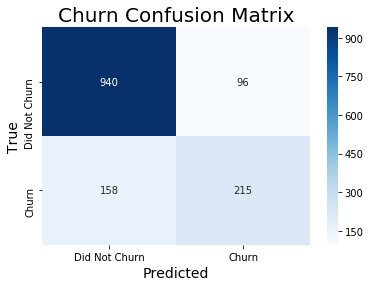

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.69      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



In [10]:
# Generate results from random forest on all OHE feature dataset
y_pred_all_lr = best_lr_all.predict(X_test_all)
_ = plot_results(y_test_all, y_pred_all_lr)
cr_lr_all = plot_results(y_test_all, y_pred_all_lr, output_dict=True)

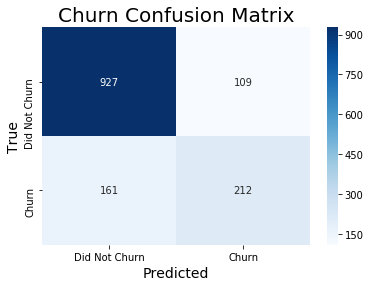

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.66      0.57      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [11]:
# Generate results from random forest on selected OHE feature dataset
y_pred_clean_lr = best_lr_clean.predict(X_test_clean)
_ = plot_results(y_test_clean, y_pred_clean_lr)
cr_lr_clean = plot_results(y_test_all, y_pred_clean_lr, output_dict=True)

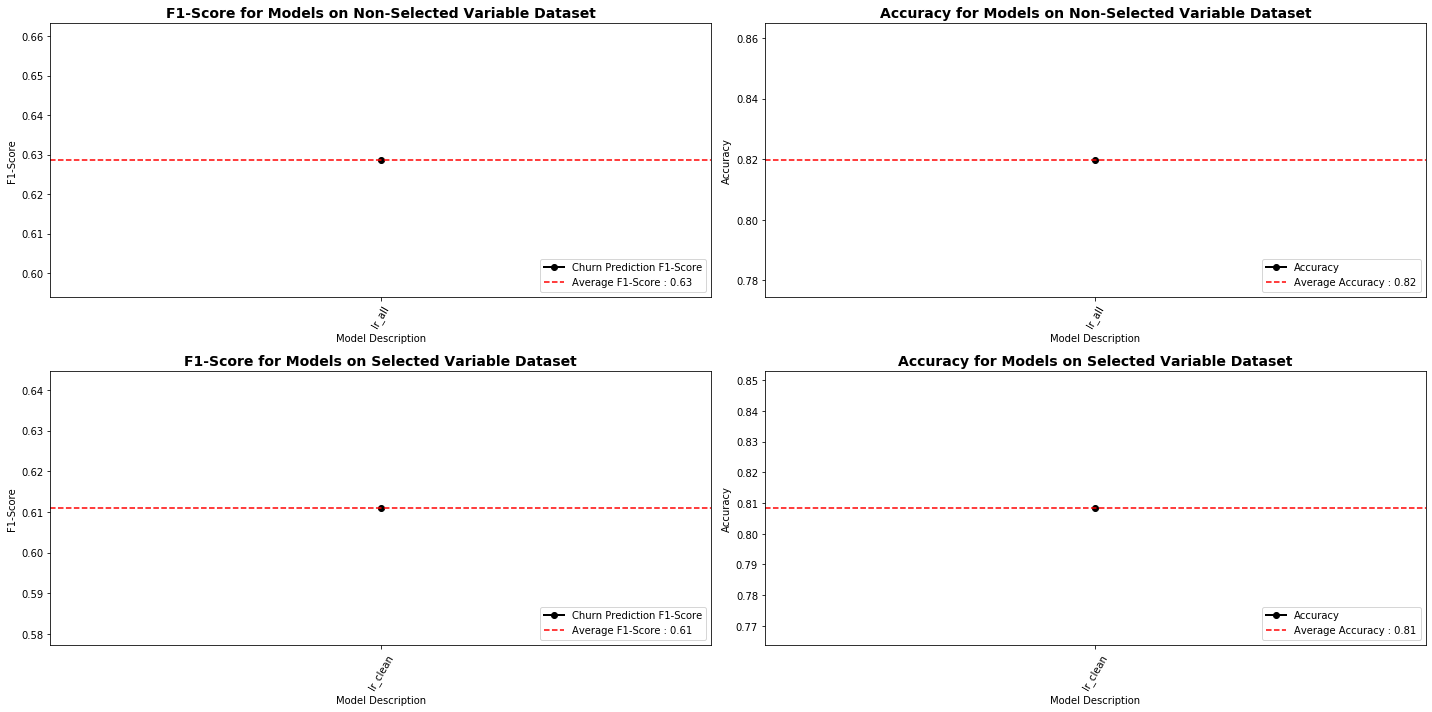

In [12]:
# Plot logistic regression results
f1_dict_all['lr_all'] = cr_lr_all['1']['f1-score']
acc_dict_all['lr_all'] = cr_lr_all['accuracy']
f1_dict_clean['lr_clean'] = cr_lr_clean['1']['f1-score']
acc_dict_clean['lr_clean'] = cr_lr_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

Using the logistic regression classifier on the holdout Telco dataset netted decent results in predicting customer churn. The dataset of selected features netted a 2% difference on F1-score and 1% difference on overall accuracy versus the non-selected feature dataset. 

The logistic regression model is the simplest model to get churn predictions yet it performed pretty well. Looking closer at the performance of logistic regression on the all feature dataset, we can see that the model predicted users that churned with 69% precision. This high precision means that whenever the model classified a user as someone who churned, it made the prediction correctly 69% of the time. If Telco wants to target users who churned by offering lower priced services but have budgetary restrictions on these offers, this model is pretty good at making sure that Telco doesn't waste money offering services to people who aren't at risk of churning.

---

## Random Tree Classifier

Random tree classification is a good model to find the best-fit model. The basis of a random tree is that given a set of data and its predicted features, what's the best way to find its label? The random tree does this by selecting data and features randomly and making decision boundaries on the given features to reduce the impurity of points divided by each boundary. Impurity is the ratio between the majority of points bound by the decision boundaries and the total number of points within the same boundary. Using the best classifier function that we defined earlier, we can find the best-fit decision tree for the Telco dataset.

In [13]:
# Create best-fit random tree model for all OHE feature dataset and selected OHE feature dataset
from sklearn.tree import DecisionTreeClassifier

# Parameters for GridSearchCV
tree_params = { 'criterion' : ['gini', 'entropy'],
                  'max_features' : ['sqrt'],
                  'min_samples_leaf' : [1, 3, 5],
                  'random_state' : [42]}
tree = DecisionTreeClassifier()

# Find best random tree classifier for all OHE feature dataset
best_tree_all = best_clf(tree, tree_params, X_train_all, y_train_all)

# Find best random tree classifier for selected OHE feature dataset
best_tree_clean = best_clf(tree, tree_params, X_train_clean, y_train_clean)

# Print list of best parameters from GridSearchCV
print(f'Best Parameters for Decision Tree on All Features: {best_tree_all.best_params_}')
print('-------------------------------------------')
print(f'Best Parameters for Decision Tree on Selected Features: {best_tree_clean.best_params_}')

Best Parameters for Decision Tree on All Features: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'random_state': 42}
-------------------------------------------
Best Parameters for Decision Tree on Selected Features: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'random_state': 42}


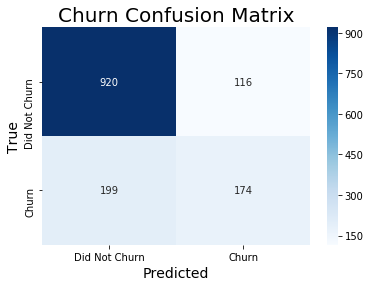

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1036
           1       0.60      0.47      0.52       373

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409



In [14]:
# Generate results from random forest on all OHE feature dataset
y_pred_all_tree = best_tree_all.predict(X_test_all)
_ = plot_results(y_test_all, y_pred_all_tree)
cr_tree_all = plot_results(y_test_all, y_pred_all_tree, output_dict=True)

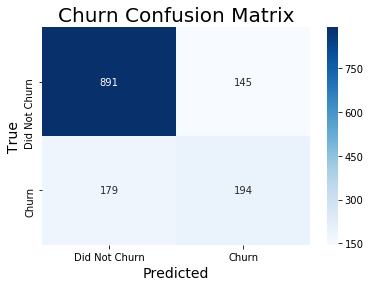

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1036
           1       0.57      0.52      0.54       373

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



In [15]:
# Generate results from random forest on selected OHE feature dataset
y_pred_clean_tree = best_tree_clean.predict(X_test_clean)
_ = plot_results(y_test_clean, y_pred_clean_tree)
cr_tree_clean = plot_results(y_test_all, y_pred_clean_tree, output_dict=True)

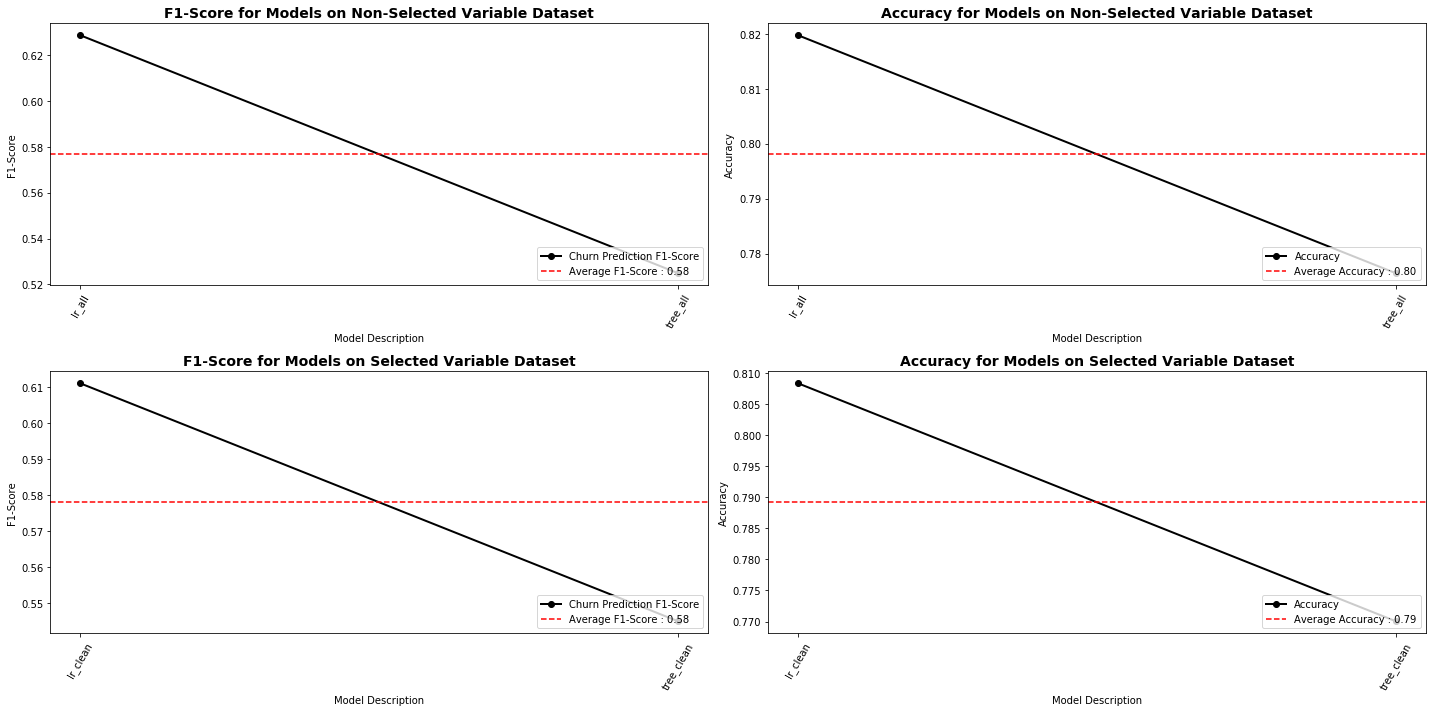

In [16]:
# Plot logistic regression results
f1_dict_all['tree_all'] = cr_tree_all['1']['f1-score']
acc_dict_all['tree_all'] = cr_tree_all['accuracy']
f1_dict_clean['tree_clean'] = cr_tree_clean['1']['f1-score']
acc_dict_clean['tree_clean'] = cr_tree_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

Random tree classification performed around 10% worse in F1-score and 12% worse in overall accuracy than logistic regression. Overfitting is to be expected of random tree classification since random trees are much better at classifying the training data well while failing to generalize the classification on unseen holdout data. 

While the random tree classifier is better than randomly guessing 50-50 on the selected feature dataset, it's not that great at predicting users on the non-selected feature dataset. Random tree on the non-selected feature dataset exhibits a 47% recall rate, which means that 53% of the users at risk of churning weren't labelled as such. So if Telco were to use this classifier to predict user churn, 53% of the users who end up churning will not receive an incentive to prevent them from churning.

---

## Random Forest Classifier

Random forest classification takes predictions from hundreds or thousands of random trees and classifies the data based on majority vote. Since each random tree is modelled after a random set of data and a random set of features from that data, each tree individually is good at predicting on the data that it is given to fit on. However, by taking hundreds or thousands of trees that all work well individually and using each tree to predict on a new set of data, on average each tree makes a correct guess than not and improves overall model performance based on its majority rule voting system. 

Since each tree is flexible at adjusting their decision boundaries on the features at hand, decision trees have low bias. However, with the majority voting system with random forests, the classifier also has low variance in how it would perform in training versus new data. As such, a random forest, typically, is a good model to use for a classification task like this one.

In [17]:
# Create best-fit random forest models for all OHE feature dataset and selected OHE feature dataset
from sklearn.ensemble import RandomForestClassifier

# Parameters for GridSearchCV
rf_params = {'n_estimators' : [500, 1000, 5000],
          'criterion' : ['gini', 'entropy'],
          'max_features' : ['sqrt'],
          'min_samples_leaf' : [1, 3],
          'random_state' : [42]}
rf = RandomForestClassifier()

# Find best random forest classifier for all OHE feature dataset
best_rf_all = best_clf(rf, rf_params, X_train_all, y_train_all)

# Find best random forest classifier for selected OHE feature dataset
best_rf_clean = best_clf(rf, rf_params, X_train_clean, y_train_clean)

# Print list of best parameters from GridSearchCV
print(f'Best Parameters for Random Forest on All Features: {best_rf_all.best_params_}')
print('-------------------------------------------')
print(f'Best Parameters for Random Forest on Selected Features: {best_rf_clean.best_params_}')

Best Parameters for Random Forest on All Features: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500, 'random_state': 42}
-------------------------------------------
Best Parameters for Random Forest on Selected Features: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 1000, 'random_state': 42}


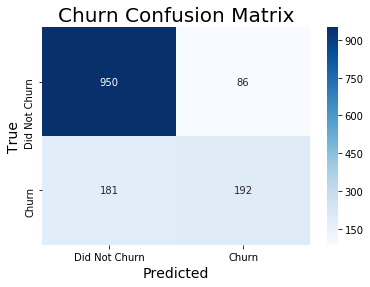

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [18]:
# Generate results from random forest on all OHE feature dataset
y_pred_all_rf = best_rf_all.predict(X_test_all)
_ = plot_results(y_test_all, y_pred_all_rf)
cr_rf_all = plot_results(y_test_all, y_pred_all_rf, output_dict=True)

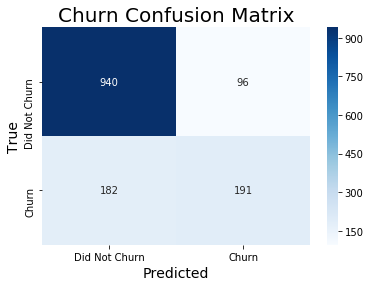

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.51      0.58       373

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [19]:
# Generate results from random forest on selected OHE feature dataset
y_pred_clean_rf = best_rf_clean.predict(X_test_clean)
_ = plot_results(y_test_clean, y_pred_clean_rf)
cr_rf_clean = plot_results(y_test_all, y_pred_clean_rf, output_dict=True)

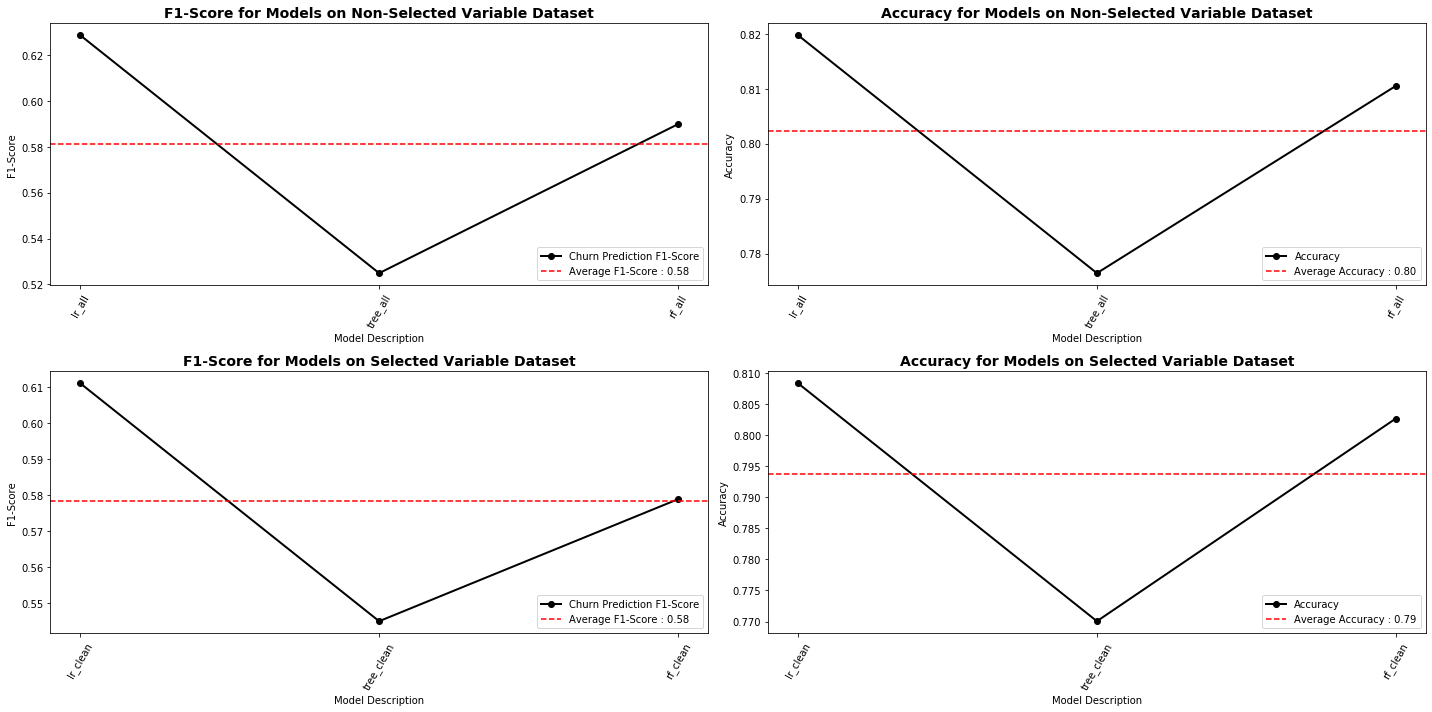

In [20]:
# Plot logistic regression results
f1_dict_all['rf_all'] = cr_rf_all['1']['f1-score']
acc_dict_all['rf_all'] = cr_rf_all['accuracy']
f1_dict_clean['rf_clean'] = cr_rf_clean['1']['f1-score']
acc_dict_clean['rf_clean'] = cr_rf_clean['accuracy']
_ = plot_f1_acc(f1_dict_all, acc_dict_all, f1_dict_clean, acc_dict_clean)

Modeling the Telco dataset with a random forest classifier shows a measurable improvement in model performance from using a random tree with a 6% and 3% improvement in F1 score and a 2% and 3% improvement on overall accuracy for the non-selected and selected feature datasets, respectively. However, random forest model was still less still performed worse than logistic regression. 

This performance difference is due to the amount of training data provided. Random forest classification works better with more data to train on since it's able to observe more relationships between data given more data. The performance of logistic regression is limited since it assumes all variables are independent from one another so more data won't necessarily affect how the model interprets relationships between all the features provided.

For the Telco dataset that we were given, there are 7045 total observations. From the 7045 observations, 1409 observations were used to predict and 5636 observations were used to train each model. After Telco observes more users that do or don't churn, the random forest classifier's performance can be improved by training the random forest while logistic regression won't improve all that much.

So, for this part of the project, although we found that logistic regression on the non-selected feature dataset was the best performing model of the three we looked at, the random forest classifier will improve after recording more people churning or not churning. In conclusion, the random forest classifier is robust, can be used to better effect with more observations, and should be used to predict customer churn for Telco customers in the future.